# Premier League Betting App – Match Outcome & Score Prediction

This notebook implements the pipeline described in the project proposal:

- **Client:** Premier League Betting App  
- **Goal:**  
  - Classification: Predict the **match outcome**  
    - `0` = Home Win, `1` = Away Win, `2` = Draw  
  - Regression: Predict the **final score** (home & away goals).  
- **Data:** Premier League matchup stats (e.g., Kaggle datasets for seasons 2019/2020, 2020/2021, 2021/2022) concatenated into a single dataset.  
- **Models:**  
  - **Classification:** SVM, Random Forest, Logistic Regression  
  - **Regression:** Linear Regression (with regularization), Random Forest Regressor, Gradient Boosting Regressor  
- **Framework:** Preprocessing → Data splitting → Hyperparameter tuning → Model training → Validation → Visualization


In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Preprocessing & model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Regression models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, r2_score
)

pd.set_option("display.max_columns", 100)


## 1. Data Loading




In [2]:
# TODO: Update these paths to match your local dataset files
path_2019_2020 = "2019-20.csv"
path_2020_2021 = "2020-2021.csv"
path_2021_2022 = "2021-2022.csv"

# Load datasets
df_19_20 = pd.read_csv(path_2019_2020)
df_20_21 = pd.read_csv(path_2020_2021)
df_21_22 = pd.read_csv(path_2021_2022)

# Concatenate datasets
df = pd.concat([df_19_20, df_20_21, df_21_22], ignore_index=True)

print(df.shape)
df.head()


(1020, 106)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,...,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,H,M Oliver,15,12,7,5,9,9,11,2,0,2,0,0,1.14,10.00,19.00,1.14,8.25,18.50,1.15,8.00,18.00,1.15,9.59,18.05,1.12,8.5,21.00,1.14,9.5,23.00,1.16,10.00,23.00,1.14,8.75,19.83,1.40,3.00,...,-2.25,1.96,1.94,1.97,1.95,1.97,2.00,1.94,1.94,1.14,9.50,21.00,1.14,9.0,20.00,1.15,8.00,18.00,1.14,10.43,19.63,1.11,9.5,21.00,1.14,9.50,23.00,1.16,10.50,23.00,1.14,9.52,19.18,1.3,3.50,1.34,3.44,1.36,3.76,1.32,3.43,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,A,M Dean,5,14,3,9,6,13,1,1,2,2,0,0,12.00,6.50,1.22,11.50,5.75,1.26,11.00,6.10,1.25,11.68,6.53,1.26,13.00,6.0,1.24,12.00,6.5,1.25,13.00,6.75,1.29,11.84,6.28,1.25,1.44,2.75,...,1.75,2.00,1.90,2.02,1.90,2.02,1.92,1.99,1.89,12.00,7.00,1.25,11.00,6.0,1.26,11.00,6.10,1.25,11.11,6.68,1.27,11.00,6.5,1.24,12.00,6.50,1.25,13.00,7.00,1.29,11.14,6.46,1.26,1.4,3.00,1.43,3.03,1.50,3.22,1.41,2.91,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,K Friend,13,8,3,3,10,19,3,4,2,1,0,0,1.95,3.60,3.60,1.95,3.60,3.90,1.97,3.55,3.80,2.04,3.57,3.90,2.00,3.5,3.80,2.00,3.6,4.00,2.06,3.65,4.00,2.01,3.53,3.83,1.90,1.90,...,-0.50,2.01,1.89,2.04,1.88,2.04,1.91,2.00,1.88,1.95,3.70,4.20,1.95,3.6,3.90,1.97,3.55,3.85,1.98,3.67,4.06,1.95,3.6,3.90,2.00,3.60,4.00,2.03,3.70,4.20,1.98,3.58,3.96,1.9,1.90,1.94,1.97,1.97,1.98,1.91,1.92,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,D,G Scott,10,11,4,3,6,12,2,7,0,0,0,0,2.62,3.20,2.75,2.65,3.20,2.75,2.65,3.20,2.75,2.71,3.31,2.81,2.70,3.2,2.75,2.70,3.3,2.80,2.80,3.33,2.85,2.68,3.22,2.78,2.10,1.72,...,0.00,1.92,1.98,1.93,2.00,1.94,2.00,1.91,1.98,2.70,3.25,2.90,2.65,3.1,2.85,2.60,3.20,2.85,2.71,3.19,2.90,2.62,3.2,2.80,2.70,3.25,2.90,2.72,3.26,2.95,2.65,3.18,2.88,2.1,1.72,2.19,1.76,2.25,1.78,2.17,1.71,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,D,J Moss,6,10,2,3,16,14,6,2,2,1,0,1,3.00,3.25,2.37,3.20,3.20,2.35,3.10,3.20,2.40,3.21,3.37,2.39,3.10,3.3,2.35,3.20,3.3,2.45,3.21,3.40,2.52,3.13,3.27,2.40,2.20,1.66,...,0.25,1.85,2.05,1.88,2.05,1.88,2.09,1.84,2.04,3.40,3.50,2.25,3.30,3.3,2.25,3.40,3.30,2.20,3.37,3.45,2.27,3.30,3.3,2.25,3.40,3.30,2.25,3.55,3.50,2.34,3.41,3.37,2.23,2.2,1.66,2.22,1.74,2.28,1.77,2.17,1.71,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93


## 2. Exploratory Data Analysis (EDA)

Quick sanity checks: data types, missing values, and simple distributions.


In [3]:
# Overview of the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Columns: 106 entries, Div to AvgCAHA
dtypes: float64(82), int64(16), object(8)
memory usage: 844.8+ KB


In [4]:
# Check basic statistics for numerical columns
df.describe().T


,count,mean,std,min,25%,50%,75%,max
FTHG,1020.0,1.445098,1.290839,0.00,0.0000,1.00,2.00,9.00
FTAG,1020.0,1.311765,1.249478,0.00,0.0000,1.00,2.00,9.00
HTHG,1020.0,0.669608,0.840380,0.00,0.0000,0.00,1.00,5.00
HTAG,1020.0,0.595098,0.804657,0.00,0.0000,0.00,1.00,5.00
HS,1020.0,13.407843,5.565061,1.00,9.0000,13.00,17.00,31.00
...,...,...,...,...,...,...,...,...
PCAHA,1020.0,1.973029,0.106140,1.30,1.8900,1.97,2.05,2.38
MaxCAHH,1020.0,2.015382,0.123176,1.80,1.9300,2.01,2.09,3.95
MaxCAHA,1020.0,2.037598,0.110921,1.30,1.9500,2.04,2.12,2.52
AvgCAHH,1020.0,1.932176,0.108477,1.70,1.8500,1.93,2.01,3.66


In [5]:
# Check missing values
df.isna().mean().sort_values(ascending=False).head(20)


IWCA        0.002941
IWCD        0.002941
IWCH        0.002941
B365<2.5    0.000980
B365>2.5    0.000980
B365CAHA    0.000980
B365CAHH    0.000980
Div         0.000000
B365CD      0.000000
PSCA        0.000000
PSCD        0.000000
PSCH        0.000000
BWCA        0.000000
BWCD        0.000000
BWCH        0.000000
B365CA      0.000000
AvgAHA      0.000000
B365CH      0.000000
WHCD        0.000000
AvgAHH      0.000000
dtype: float64

## 3. Feature Engineering & Target Definition



In [6]:
# Feature Engineering for Classification (Match Outcome Prediction)
# Similar to regression notebook - using historical performance only

# Keep only relevant columns
features_to_keep = ['HomeTeam', 'AwayTeam', 'Date', 'FTHG', 'FTAG', 'FTR']
df_features = df[features_to_keep].copy()

# Convert Date to datetime
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')

print(f"Shape after feature selection: {df_features.shape}")
print(f"\nColumns kept: {list(df_features.columns)}")
print(f"\nTarget variable (FTR) distribution:")
print(df_features['FTR'].value_counts())
print(f"\nSample data:")
df_features.head()

Shape after feature selection: (1020, 6)

Columns kept: ['HomeTeam', 'AwayTeam', 'Date', 'FTHG', 'FTAG', 'FTR']

Target variable (FTR) distribution:
FTR
H    418
A    365
D    237
Name: count, dtype: int64

Sample data:


,HomeTeam,AwayTeam,Date,FTHG,FTAG,FTR
0,Liverpool,Norwich,2019-08-09,4,1,H
1,West Ham,Man City,2019-08-10,0,5,A
2,Bournemouth,Sheffield United,2019-08-10,1,1,D
3,Burnley,Southampton,2019-08-10,3,0,H
4,Crystal Palace,Everton,2019-08-10,0,0,D


In [7]:
# Create season-to-date cumulative statistics
# Extract season from date (August start = new season)
df_features['Season'] = df_features['Date'].dt.year
df_features.loc[df_features['Date'].dt.month >= 8, 'Season'] = df_features['Date'].dt.year
df_features.loc[df_features['Date'].dt.month < 8, 'Season'] = df_features['Date'].dt.year - 1

# Initialize cumulative feature columns
df_features['home_goals_scored_avg'] = np.nan
df_features['home_goals_conceded_avg'] = np.nan
df_features['home_matches_played'] = 0
df_features['away_goals_scored_avg'] = np.nan
df_features['away_goals_conceded_avg'] = np.nan
df_features['away_matches_played'] = 0

# Calculate cumulative stats for each team in each season
for team in df_features['HomeTeam'].unique():
    # Home matches
    for season in df_features[df_features['HomeTeam'] == team]['Season'].unique():
        season_mask = (df_features['HomeTeam'] == team) & (df_features['Season'] == season)
        season_indices = df_features[season_mask].sort_values('Date').index
        
        goals_scored = df_features.loc[season_indices, 'FTHG']
        goals_conceded = df_features.loc[season_indices, 'FTAG']
        
        # Cumulative averages (shift to exclude current match)
        df_features.loc[season_indices, 'home_goals_scored_avg'] = goals_scored.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'home_goals_conceded_avg'] = goals_conceded.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'home_matches_played'] = range(len(season_indices))
    
    # Away matches
    for season in df_features[df_features['AwayTeam'] == team]['Season'].unique():
        season_mask = (df_features['AwayTeam'] == team) & (df_features['Season'] == season)
        season_indices = df_features[season_mask].sort_values('Date').index
        
        goals_scored = df_features.loc[season_indices, 'FTAG']
        goals_conceded = df_features.loc[season_indices, 'FTHG']
        
        # Cumulative averages (shift to exclude current match)
        df_features.loc[season_indices, 'away_goals_scored_avg'] = goals_scored.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'away_goals_conceded_avg'] = goals_conceded.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'away_matches_played'] = range(len(season_indices))

# Fill initial NaN values (first match of each season) with overall league averages
league_avg_goals = df_features['FTHG'].mean()
df_features['home_goals_scored_avg'] = df_features['home_goals_scored_avg'].fillna(league_avg_goals)
df_features['home_goals_conceded_avg'] = df_features['home_goals_conceded_avg'].fillna(league_avg_goals)
df_features['away_goals_scored_avg'] = df_features['away_goals_scored_avg'].fillna(league_avg_goals)
df_features['away_goals_conceded_avg'] = df_features['away_goals_conceded_avg'].fillna(league_avg_goals)

print(f"\nShape after adding cumulative features: {df_features.shape}")
print("\nSeason-to-date features created:")
print("- home_goals_scored_avg, home_goals_conceded_avg, home_matches_played")
print("- away_goals_scored_avg, away_goals_conceded_avg, away_matches_played")
print("\nVerification - Liverpool's first 3 home matches in 2019:")
df_features[(df_features['HomeTeam'] == 'Liverpool') & (df_features['Season'] == 2019)].head(3)[
    ['Date', 'HomeTeam', 'AwayTeam', 'home_matches_played', 'home_goals_scored_avg', 'FTHG', 'FTAG', 'FTR']
]


Shape after adding cumulative features: (1020, 13)

Season-to-date features created:
- home_goals_scored_avg, home_goals_conceded_avg, home_matches_played
- away_goals_scored_avg, away_goals_conceded_avg, away_matches_played

Verification - Liverpool's first 3 home matches in 2019:


,Date,HomeTeam,AwayTeam,home_matches_played,home_goals_scored_avg,FTHG,FTAG,FTR
0,2019-08-09,Liverpool,Norwich,0,1.445098,4,1,H
26,2019-08-24,Liverpool,Arsenal,1,4.000000,3,1,H
40,2019-09-14,Liverpool,Newcastle,2,3.500000,3,1,H


In [8]:
# Add goal difference features to capture team strength
# These features help identify when teams are evenly matched (→ draws)

df_features['home_goal_diff_avg'] = df_features['home_goals_scored_avg'] - df_features['home_goals_conceded_avg']
df_features['away_goal_diff_avg'] = df_features['away_goals_scored_avg'] - df_features['away_goals_conceded_avg']
df_features['team_strength_diff'] = df_features['home_goal_diff_avg'] - df_features['away_goal_diff_avg']


print("\nNew features:")
print("  • home_goal_diff_avg: Home team's goal difference per game")
print("  • away_goal_diff_avg: Away team's goal difference per game")
print("  • team_strength_diff: Relative strength (positive = home stronger)")

# Show example
print("\nExample - Liverpool's progression:")
df_features[(df_features['HomeTeam'] == 'Liverpool') & (df_features['Season'] == 2019)].head(3)[
    ['Date', 'AwayTeam', 'home_goal_diff_avg', 'away_goal_diff_avg', 'team_strength_diff', 'FTR']
]


New features:
  • home_goal_diff_avg: Home team's goal difference per game
  • away_goal_diff_avg: Away team's goal difference per game
  • team_strength_diff: Relative strength (positive = home stronger)

Example - Liverpool's progression:


,Date,AwayTeam,home_goal_diff_avg,away_goal_diff_avg,team_strength_diff,FTR
0,2019-08-09,Norwich,0.0,0.0,0.0,H
26,2019-08-24,Arsenal,3.0,1.0,2.0,H
40,2019-09-14,Newcastle,2.5,-0.5,3.0,H


In [9]:
# Define features (X) and target (y) for classification
categorical_features = ['HomeTeam', 'AwayTeam']
numerical_features = ['home_goals_scored_avg', 'home_goals_conceded_avg', 'home_matches_played',
                      'away_goals_scored_avg', 'away_goals_conceded_avg', 'away_matches_played',
                      'home_goal_diff_avg', 'away_goal_diff_avg', 'team_strength_diff']

X = df_features[categorical_features + numerical_features].copy()

# Target: Match outcome (FTR)
# H = Home Win, A = Away Win, D = Draw
# Convert to numeric: 0 = Home Win, 1 = Away Win, 2 = Draw
outcome_mapping = {'H': 0, 'A': 1, 'D': 2}
y_clf = df_features['FTR'].map(outcome_mapping)

print(f"\nFeatures (X): {X.shape}")
print(f"  Categorical: {categorical_features}")
print(f"  Numerical: {numerical_features}")
print(f"\nTarget (y_clf): {y_clf.shape}")
print(f"  0 = Home Win, 1 = Away Win, 2 = Draw")
print(f"\nTarget distribution:")
print(y_clf.value_counts().sort_index())
print(f"\nPercentages:")
print(y_clf.value_counts(normalize=True).sort_index() * 100)


Features (X): (1020, 11)
  Categorical: ['HomeTeam', 'AwayTeam']
  Numerical: ['home_goals_scored_avg', 'home_goals_conceded_avg', 'home_matches_played', 'away_goals_scored_avg', 'away_goals_conceded_avg', 'away_matches_played', 'home_goal_diff_avg', 'away_goal_diff_avg', 'team_strength_diff']

Target (y_clf): (1020,)
  0 = Home Win, 1 = Away Win, 2 = Draw

Target distribution:
FTR
0    418
1    365
2    237
Name: count, dtype: int64

Percentages:
FTR
0    40.980392
1    35.784314
2    23.235294
Name: proportion, dtype: float64


### Feature Engineering Summary

**Approach:** Historical performance only (no betting odds)

**Features (11 total):**
- **2 Categorical:** HomeTeam, AwayTeam
- **9 Numerical:** Season-to-date cumulative statistics
  - `home_goals_scored_avg` - Home team's avg goals scored so far this season
  - `home_goals_conceded_avg` - Home team's avg goals conceded so far this season
  - `home_matches_played` - Home team's matches played this season
  - `away_goals_scored_avg` - Away team's avg goals scored so far this season
  - `away_goals_conceded_avg` - Away team's avg goals conceded so far this season
  - `away_matches_played` - Away team's matches played this season
  - `home_goal_diff_avg` - Home team's goal difference per game 
  - `away_goal_diff_avg` - Away team's goal difference per game 
  - `team_strength_diff` - Relative team strength (home - away) 
**Target:** Match outcome (0 = Home Win, 1 = Away Win, 2 = Draw)

**Key Design:**
- Features use only data from BEFORE each match (no data leakage)
- First game of each season uses league average
- Cumulative stats update after each game within the season
- **Goal difference features help identify evenly-matched teams (draws)**

## 4. Train–Test Split

**Time-Based Split (No Data Leakage):**

- **Training set:** 2019-20 + 2020-21 seasons (640 matches)  
- **Test set:** 2021-22 season (380 matches)  

This approach:
- Trains on historical data only
- Tests on future season (realistic prediction scenario)
- Uses cumulative season-to-date stats as features
- Performs **5-fold cross-validation** on training set during hyperparameter tuning


In [10]:
# Time-Based Train/Test Split (same as regression notebook)
# Train: 2019-20 + 2020-21 seasons
# Test: 2021-22 season

# Add Season column to X for filtering
X['Season'] = df_features['Season']

# Create time-based split masks
train_mask = X['Season'].isin([2019, 2020])
test_mask = X['Season'] == 2021

# Split features and target
X_train = X[train_mask].drop('Season', axis=1).copy()
X_test = X[test_mask].drop('Season', axis=1).copy()

y_cls_train = y_clf[train_mask].copy()
y_cls_test = y_clf[test_mask].copy()


print(f"\nTraining Set:")
print(f"  Seasons: 2019-20, 2020-21")
print(f"  Samples: {len(X_train)}")
print(f"  Outcome distribution:")
print(y_cls_train.value_counts().sort_index())

print(f"\nTest Set:")
print(f"  Season: 2021-22")
print(f"  Samples: {len(X_test)}")
print(f"  Outcome distribution:")
print(y_cls_test.value_counts().sort_index())

print(f"\nSplit Ratio: {len(X_test)/(len(X_train)+len(X_test))*100:.1f}% test")
print("\nNote: Model trained on past seasons, tested on future season")

# Remove Season from original X to keep it clean
X = X.drop('Season', axis=1)


Training Set:
  Seasons: 2019-20, 2020-21
  Samples: 640
  Outcome distribution:
FTR
0    255
1    236
2    149
Name: count, dtype: int64

Test Set:
  Season: 2021-22
  Samples: 380
  Outcome distribution:
FTR
0    163
1    129
2     88
Name: count, dtype: int64

Split Ratio: 37.3% test

Note: Model trained on past seasons, tested on future season


## 5. Preprocessing Pipelines



In [11]:
# Preprocessing pipelines for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

print("Preprocessing pipeline created:")
print(f"  Categorical features: {categorical_features}")
print(f"    → OneHotEncoder")
print(f"  Numerical features: {numerical_features}")
print(f"    → StandardScaler")
print("\nPreprocessor ready for model training!")

Preprocessing pipeline created:
  Categorical features: ['HomeTeam', 'AwayTeam']
    → OneHotEncoder
  Numerical features: ['home_goals_scored_avg', 'home_goals_conceded_avg', 'home_matches_played', 'away_goals_scored_avg', 'away_goals_conceded_avg', 'away_matches_played', 'home_goal_diff_avg', 'away_goal_diff_avg', 'team_strength_diff']
    → StandardScaler

Preprocessor ready for model training!


## 6. Classification – Match Outcome

We train and tune:

- **SVM (SVC)** – tuning `kernel`, `C`, `gamma`  
- **RandomForestClassifier** – tuning `n_estimators`, `max_depth`, `min_samples_split`  
- **LogisticRegression** – tuning `penalty` (L1/L2) and `C`  


In [12]:
classification_results = {}

# Helper function to run GridSearchCV and store results
def run_classification_grid_search(model, param_grid, model_name):
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1,
    )
    grid.fit(X_train, y_cls_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    acc = accuracy_score(y_cls_test, y_pred)
    prec = precision_score(y_cls_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_cls_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_cls_test, y_pred, average="weighted", zero_division=0)
    
    classification_results[model_name] = {
        "best_params": grid.best_params_,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "best_model": best_model,
        "y_pred": y_pred,
    }
    
    print(f"\nModel: {model_name}")
    print("Best params:", grid.best_params_)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted): {prec:.4f}")
    print(f"Recall (weighted): {rec:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_cls_test, y_pred, zero_division=0))
    
    return best_model, y_pred


In [13]:
# 6.1 SVM (SVC)
svm_param_grid = {
    "model__kernel": ["rbf", "linear"],
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
}

svm_model, svm_y_pred = run_classification_grid_search(
    SVC(probability=True, class_weight='balanced'),
    svm_param_grid,
    model_name="SVM"
)


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Model: SVM
Best params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Accuracy: 0.4632
Precision (weighted): 0.4882
Recall (weighted): 0.4632
F1-score (weighted): 0.4627

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59       163
           1       0.58      0.34      0.43       129
           2       0.25      0.32      0.28        88

    accuracy                           0.46       380
   macro avg       0.46      0.43      0.43       380
weighted avg       0.49      0.46      0.46       380



In [14]:
# 6.2 Random Forest Classifier
rf_cls_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
}

rf_cls_model, rf_cls_y_pred = run_classification_grid_search(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    rf_cls_param_grid,
    model_name="RandomForestClassifier"
)


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Model: RandomForestClassifier
Best params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Accuracy: 0.4447
Precision (weighted): 0.4128
Recall (weighted): 0.4447
F1-score (weighted): 0.4238

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.64      0.57       163
           1       0.49      0.44      0.47       129
           2       0.12      0.08      0.10        88

    accuracy                           0.44       380
   macro avg       0.37      0.39      0.38       380
weighted avg       0.41      0.44      0.42       380



In [15]:
# 6.3 Logistic Regression
log_reg_param_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.1, 1, 10],
    "model__solver": ["liblinear"],  
}

log_reg_model, log_reg_y_pred = run_classification_grid_search(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    log_reg_param_grid,
    model_name="LogisticRegression"
)


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Model: LogisticRegression
Best params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Accuracy: 0.5000
Precision (weighted): 0.4692
Recall (weighted): 0.5000
F1-score (weighted): 0.4723

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       163
           1       0.53      0.45      0.49       129
           2       0.26      0.14      0.18        88

    accuracy                           0.50       380
   macro avg       0.44      0.44      0.43       380
weighted avg       0.47      0.50      0.47       380



### 6.4 Confusion Matrices & Model Comparison

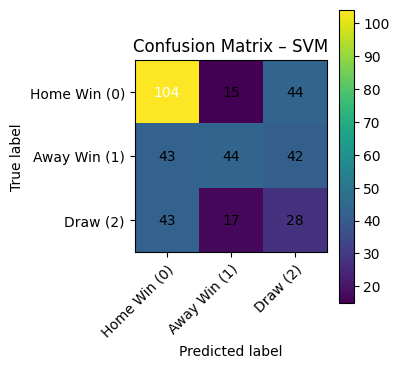

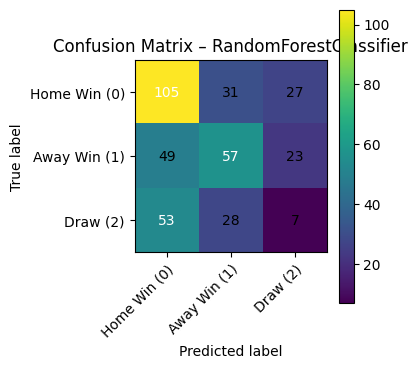

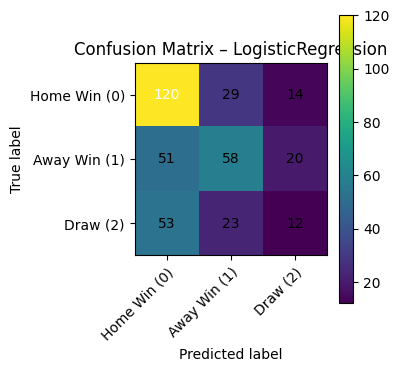

In [16]:
def plot_confusion_matrix_for_model(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=range(3),
        yticks=range(3),
        xticklabels=["Home Win (0)", "Away Win (1)", "Draw (2)"],
        yticklabels=["Home Win (0)", "Away Win (1)", "Draw (2)"],
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Annotate
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )
    plt.tight_layout()
    plt.show()


for name, res in classification_results.items():
    plot_confusion_matrix_for_model(y_cls_test, res["y_pred"], f"Confusion Matrix – {name}")


In [17]:
# Compare classification models by metrics
cls_summary = pd.DataFrame(
    {
        name: {
            "accuracy": res["accuracy"],
            "precision_weighted": res["precision"],
            "recall_weighted": res["recall"],
            "f1_weighted": res["f1"],
        }
        for name, res in classification_results.items()
    }
).T

cls_summary.sort_values("accuracy", ascending=False)


,accuracy,precision_weighted,recall_weighted,f1_weighted
LogisticRegression,0.500000,0.469200,0.500000,0.472256
SVM,0.463158,0.488209,0.463158,0.462676
RandomForestClassifier,0.444737,0.412832,0.444737,0.423775


### 6.5 Feature Importance (Random Forest)

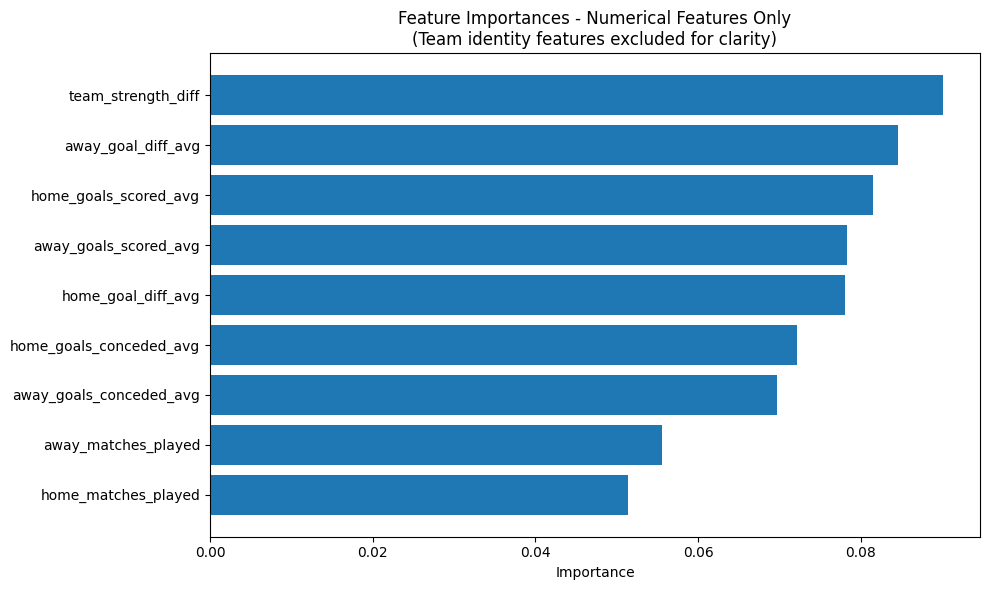


Numerical Features (shown in plot):
  team_strength_diff             0.0901 (9.0%)
  away_goal_diff_avg             0.0846 (8.5%)
  home_goals_scored_avg          0.0815 (8.2%)
  away_goals_scored_avg          0.0783 (7.8%)
  home_goal_diff_avg             0.0781 (7.8%)
  home_goals_conceded_avg        0.0722 (7.2%)
  away_goals_conceded_avg        0.0697 (7.0%)
  away_matches_played            0.0556 (5.6%)
  home_matches_played            0.0513 (5.1%)
  All HomeTeam + AwayTeam features: 0.3385 (33.9%)

Key Insight:
  • Team strength difference is the most important feature
  • Historical performance metrics dominate over team identity
  • Goal difference features (added for draw prediction) are highly valuable


In [18]:
# Extract feature importance from Random Forest model
# Get the trained model from the pipeline
rf_model_step = rf_cls_model.named_steps['model']

# Get feature names after preprocessing
# Categorical features (one-hot encoded)
onehot_encoder = rf_cls_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

# Numerical features (unchanged names)
num_feature_names = numerical_features

# Combine all feature names
all_feature_names = list(cat_feature_names) + num_feature_names

# Get feature importances
importances = rf_model_step.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

numerical_importance = feature_importance_df[
    ~feature_importance_df['feature'].str.contains('HomeTeam_|AwayTeam_')
].copy()

# Calculate total importance of team features for context
team_importance = feature_importance_df[
    feature_importance_df['feature'].str.contains('HomeTeam_|AwayTeam_')
]['importance'].sum()

# Plot numerical features only
plt.figure(figsize=(10, 6))
plt.barh(range(len(numerical_importance)), numerical_importance['importance'])
plt.yticks(range(len(numerical_importance)), numerical_importance['feature'])
plt.xlabel('Importance')
plt.title('Feature Importances - Numerical Features Only\n(Team identity features excluded for clarity)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Show summary
print(f"\nNumerical Features (shown in plot):")
for idx, row in numerical_importance.iterrows():
    print(f"  {row['feature']:30} {row['importance']:.4f} ({row['importance']*100:.1f}%)")

print(f"  All HomeTeam + AwayTeam features: {team_importance:.4f} ({team_importance*100:.1f}%)")
print(f"\nKey Insight:")
print(f"  • Team strength difference is the most important feature")
print(f"  • Historical performance metrics dominate over team identity")
print(f"  • Goal difference features (added for draw prediction) are highly valuable")


### 6.6 ROC Curves (One-vs-Rest)

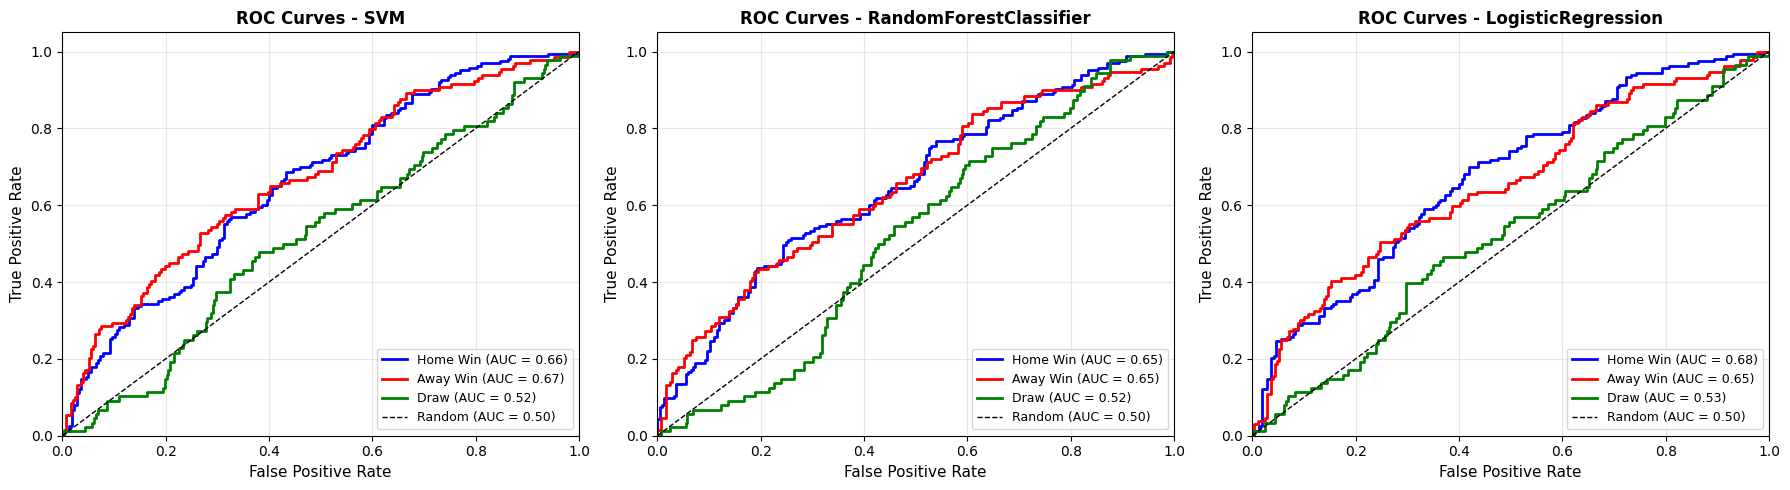

ROC AUC SUMMARY (One-vs-Rest)

SVM:
  Home Win: AUC = 0.661
  Away Win: AUC = 0.672
  Draw: AUC = 0.520

RandomForestClassifier:
  Home Win: AUC = 0.653
  Away Win: AUC = 0.651
  Draw: AUC = 0.520

LogisticRegression:
  Home Win: AUC = 0.676
  Away Win: AUC = 0.655
  Draw: AUC = 0.527


In [19]:
# Import ROC curve utilities
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_cls_test, classes=[0, 1, 2])
n_classes = 3
class_names = ['Home Win', 'Away Win', 'Draw']

# Create a figure with subplots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, res) in enumerate(classification_results.items()):
    ax = axes[idx]
    
    
    y_proba = res['best_model'].predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    colors = ['blue', 'red', 'green']
    for i, color, class_name in zip(range(n_classes), colors, class_names):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC Curves - {model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print AUC summary
print("ROC AUC SUMMARY (One-vs-Rest)")

for model_name, res in classification_results.items():
    y_proba = res['best_model'].predict_proba(X_test)
    print(f"\n{model_name}:")
    for i, class_name in enumerate(class_names):
        fpr_temp, tpr_temp, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc_temp = auc(fpr_temp, tpr_temp)
        print(f"  {class_name}: AUC = {roc_auc_temp:.3f}")


## 9. Conclusion & Next Steps

In this notebook we:

1. Loaded and concatenated multiple Premier League seasons (2019/2020–2021/2022).  
2. Preprocessed the data with imputation, scaling, and one-hot encoding.  
3. Trained and tuned **classification models** (SVM, Random Forest, Logistic Regression) to predict match outcomes.  
4. Trained and tuned **regression models** (Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor) to predict final scores.  
5. Evaluated models using appropriate metrics:  
   - **Classification:** Accuracy, Precision, Recall, F1-score  



## This section includes the conclusion and interpertation for this notebook as well as the Regression Task


## Regression

Best Model: Random Forest showed the best overall result, achieving the highest R² and lowest RMSE. (home/away combined)
Interpretation:  Although Random Forest provided the best results, the results were still at around all 1.20 RMSE and 0.08 R². These RMSE values depict that our predicted values differ from the actual by quite a bit, over a goal. The low R² values show that the features do not provide enough information. Overall, this shows that there is a lot more complexity in predicting match scores than just historical match statistics.


## Classifications
Best Model: Logistic Regression had the highest accuracy of 0.5000 and the highest F1, of 0.4722. 
Draw Prediction: Overall, although this logistic regression was found to be the best model, the results are not sufficient in actually determining match outcome. As seen by the confusion matrices, these results performed better for wins and losses, however when it comes to draws, these models had more trouble successfully predicting draws. 




## Impact: 
   1. Proof of Concept: Demonstrates feasibility of ML for football prediction
   2. Baseline Established: Provides benchmark for future improvements
   3. Feature Insights: Shows which features matter (team strength > season stats)
   4. Home Advantage: Confirms home goals are more predictable than away
   5. Business: Provides data-driven insights for sports analysts and betting strategies. The dual prediction (Outcome + Score) offers a more granular insight than just a simple win/loss prediction.

## Limitation
An 0.5 accuracy is better than random 0.33 but still indicates significant unpredictability in sport.
Models lack external factors (team fatigue, manager changes, and player injuries, team or player form). The determination of match outcome and score requires more complex data than simple historical match statistics.

## Conclusion & Future Work
Summary:  We successfully built, trained, and compared multiple ML models for both classification of match outcome and regression of final score.
Future Enhancements: Integrating Player Statistics (e.g., goal-scoring form, injury status) to improve accuracy. Implementing a Time-Series Approach to factor in team momentum and form trends.

## References please refer to the references and generative AI usages.pdf